In [1]:
# Imports, as always...
import numpy as np
from math import log2
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

# For generating prime numbers.
from Crypto.Util import number

# Notebook progress bars.
from tqdm.notebook import tqdm

from sqif import CVP, solve_cvp

# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

# Additional imports.
from scipy.optimize import curve_fit, least_squares

# Scaling to fit to.
def scaling_function(x, alpha):
    return 1 / (2 ** (alpha * x ))

# Styling for plots.
#plt.style.use('ggplot')
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

In [2]:
def give_me_a_blank_results_dataframe():
    return pd.DataFrame(
        {
            'Bit-length' : [],
            'Lattice Dimension' : [],
            'N' : [],
            'l' : [],
            'c' : [],
            '|b_op - t|^2' : [],
            'P(b_op)' : [],
            '|v_best - t|^2' : [],
            'P(v_best)' : [],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [],
            'E[|v_new - t|^2]' : []
        }
    )

In [3]:
# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

In [4]:
# The expected quality of the solution.
def expected_dist(solutions, probabilities, t):
    # Compute each solution's distance to the target.
    compute_dist = lambda x : np.linalg.norm(x - t)
    dists = np.apply_along_axis(compute_dist, 1, solutions)
    
    # Take a weighted average over these distances (weighted by their probabilities).
    return np.average(dists, weights=probabilities)

# VQAs for CVP

A very important part of Yan et al. (2022)'s proposal for a quantum-accelerated variant of Schnorr's classical factoring algorithm is that an approximate solution to the closest vector problem (CVP) could be improved upon by considering a superposition over the states forming the unit hypercube around that solution, then using a variational algorithm (they use QAOA) to sample higher quality solutions from that search space.

The relevance of this within the picture of factoring is that we have, by Schnorr's classical factoring method, a sieve-based factoring method requiring sufficiently many "smooth-relation pairs (sr-pairs)" which we may found by reducing the problem to a closest vector problem (CVP) on the prime lattice whose elemental points map to sr-pairs. The higher the quality of our solution to the CVP, the 'better' our sr-pairs are more likely to be, and so we require fewer of them to form a suitable system of equations whose solution yields (part of) a solution to the original factorisation. 

Of course, Schnorr's algorithm is deeply flawed, but that is besides the point -- we know in what ways it is flawed, and why, thanks to works such as Léo Ducas' excellent repository. Our concern, in this notebook, is that *throwing the thing into a variational algorithm is not the silver bullet*; we suggest that Yan et al. (2022)'s proposal is built on a weak claim about lattice dimension, and so we do not expect better results even when using a quantum algorithm to improve the solution to the CVP. Indeed, we doubt their methodology is sophisticated enough to even improve the CVP effectively as the lattice dimension increases, particularly as the lattice dimension is given to scale "sublinearly" based on claims that are not expected to hold.

So, in summary, the purpose of this notebook is to empirically demonstrate that their variational approach, with a Hamiltonian mapped as they describe, offers an insufficient scaling with respect to the probability to sample better solutions to the CVP and lattice dimension, and thus their approach would not scale well even when issues with Schnorr's classical approach are not fundamental (which, unfortunately, they are).

**Hopefully, we can also try out a few other quantum heuristics (e.g. VQE, AQC-PQC), and maybe even a brute-force search of the entire hyper-cube to demonstrate that the idea of 'searching around the approximate solution on the off chance a rounding operation was not so good' is wholy insufficient to solve a problem as difficult as prime factorisation.**

In [5]:
# The probability to measure the best state...
def report_algorithm_effectiveness(solutions, probabilities, approximate_solution, t):
    approximate_quality = np.linalg.norm(approximate_solution - t)
    print(f'Our approximate solution by Babai\'s algorithm has a distance to t of {round(approximate_quality, 3):.3f}.\n')
    
    # First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
    best_dist_to_target = np.inf
    best_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - t)
        
        if dist_to_target < best_dist_to_target:
            best_dist_to_target = dist_to_target
            best_prob = prob
            
    print(f'The closest we get to t is {round(best_dist_to_target, 3):.3f}, which we obtain with a probability {round(best_prob, 3):.3f}.\n')
    
    # The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
    better_cum_prob = 0
    worse_cum_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - t)
        
        if dist_to_target < approximate_quality:
            better_cum_prob += prob
        elif dist_to_target > approximate_quality:
            worse_cum_prob += prob
            
    print(f'The probability to obtain a state vector corresponding to a solution that is BETTER than the classically-obtained approximate solution is {round(better_cum_prob, 3):.3f}.')
    print(f'The probability to obtain a state vector corresponding to a solution that is WORSE than the classically-obtained approximate solution is {round(worse_cum_prob, 3):.3f}.\n')
    
    print(f'The EXPECTED distance to t is {expected_dist(solutions, probabilities, cvp.t):.3f}')

In [35]:
# The integer bit-length we'd like to solve for.
n_bits = 48

# Lattice and precision parameters.
l = 1
c = 4

# Generating a prime number for which the above lattice dimension is required.
N = number.getPrime(n_bits)
#N=1961
print(f'Integer to factor: {N}')

# Set up the CVP.
cvp = CVP()
cvp.generate_cvp(N, l=l, c=c, seed=42)
print(f'Lattice dimension: {cvp.m}')

print('\n...')

# Solve it!
solutions, probabilities, approximate_solution = solve_cvp(cvp, n_samples=1000, delta=.75, p=1, min_method='Nelder-Mead', verbose=False)
report_algorithm_effectiveness(solutions, probabilities, approximate_solution, cvp.t)

Integer to factor: 169183578713153
Lattice dimension: 8

...
Our approximate solution by Babai's algorithm has a distance to t of 13.115.

The closest we get to t is 13.115, which we obtain with a probability 0.022.

The probability to obtain a state vector corresponding to a solution that is BETTER than the classically-obtained approximate solution is 0.000.
The probability to obtain a state vector corresponding to a solution that is WORSE than the classically-obtained approximate solution is 0.978.

The EXPECTED distance to t is 16.082


## Running Experiments

In [6]:
# From-scratch QAOA-based "SQIF" algorithm on the generated CVP.
def from_scratch_qaoa_experiment(n_bits, l, c, seed=42, n_samples=1000, delta=.75, p=1):
    N = number.getPrime(n_bits)
    
    # Set up the CVP.
    cvp = CVP()
    cvp.generate_cvp(N, l=l, c=c, seed=seed)
    
    # Solve it!
    solutions, probabilities, approximate_solution, _ = solve_cvp(cvp, n_samples=n_samples, delta=delta, p=p, min_method='Nelder-Mead', verbose=False)
    
    approximate_quality = np.linalg.norm(approximate_solution - cvp.t)
    
    # Determine the quality of the SQIF algorithm's solutions to the CVP (in terms of probability).
    
    # First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
    best_dist_to_target = np.inf
    best_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < best_dist_to_target:
            best_dist_to_target = dist_to_target
            best_prob = prob
    
    # The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
    better_cum_prob = 0
    worse_cum_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < approximate_quality:
            better_cum_prob += prob
        elif dist_to_target > approximate_quality:
            worse_cum_prob += prob
            
    return pd.DataFrame(
        {
            'Bit-length' : [N.bit_length()],
            'Lattice Dimension' : [cvp.m],
            'N' : [N],
            'l' : [l],
            'c' : [c],
            '|b_op - t|^2' : [approximate_quality],
            'P(b_op)' : [1 - (better_cum_prob + worse_cum_prob)],
            '|v_best - t|^2' : [best_dist_to_target],
            'P(v_best)' : [best_prob],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [better_cum_prob],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [worse_cum_prob],
            'E[|v_new - t|^2]' : [expected_dist(solutions, probabilities, cvp.t)]
        }
    )

from_scratch_qaoa_experiment(11, l=1, c=1.5)

,Bit-length,Lattice Dimension,N,l,c,|b_op - t|^2,P(b_op),|v_best - t|^2,P(v_best),P(|v_new - t|^2 < |b_op - t|^2),P(|v_new - t|^2 > |b_op - t|^2),E[|v_new - t|^2]
0,11,3,1523,1,1.5,5.91608,0.346,5.744563,0.21,0.486,0.168,5.976683


### QAOA-based, Independent-training

The SQIF algorithm using a QAOA-based quantum "speed-up" mechanism, independently training and running in each input semi-prime. This is taxing on resources, and only really gives us useful insight into the algorithm as applied as a framework requiring a full training setup for every input, but it is necessary to understand a broad range of input independently under the same framework.

In [14]:
# For reference, with n_bits in [5, 50] and 5 repeats for each, p=1 takes ~5 min, p=2 takes ~30 min, p=3 takes ~75 min.

# Number of QAOA layers.
for p in tqdm(range(1, 4)):
    results = give_me_a_blank_results_dataframe()
    
    # Bit-length for the input semi-prime.
    for n_bits in range(5, 51):
        # How many repeats for each bit-length.
        for _ in range(5):
            experiment_outcome = from_scratch_qaoa_experiment(n_bits, l=1, c=1.5, seed=42, p=p)
            results = pd.concat([results, experiment_outcome])
            
    results.to_csv(f'./results/quantum-accelerated-cvp/qaoa-based-(p={p})-independent-training.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

In [310]:
# Repeating the relatively cheap p=1 many more times.
# For reference, with n_bits in [5, 64] and 50 repeats each, this takes ~1 hour 50 min.  
results = give_me_a_blank_results_dataframe()

for n_bits in tqdm(range(5, 65)):
    for _ in range(50):
        experiment_outcome = from_scratch_qaoa_experiment(n_bits, l=1, c=3, seed=42, p=1)
        results = pd.concat([results, experiment_outcome])
        
results.to_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-independent-training-large.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

In [353]:
# Repeating the not-too-expensive p=2 many more times.
# For reference, with n_bits in [5, 64] and 50 repeats each, this takes ~10 hours 30 min.  
results = give_me_a_blank_results_dataframe()

for n_bits in tqdm(range(5, 65)):
    for _ in range(50):
        experiment_outcome = from_scratch_qaoa_experiment(n_bits, l=1, c=3, seed=42, p=2)
        results = pd.concat([results, experiment_outcome])
        
results.to_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=2)-independent-training-large.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

In [354]:
# Repeating the not-too-expensive p=2 many more times.
# For reference, with n_bits in [5, 64] and 50 repeats each, this takes ~27 hours 15 min.  
results = give_me_a_blank_results_dataframe()

for n_bits in tqdm(range(5, 65)):
    for _ in range(50):
        experiment_outcome = from_scratch_qaoa_experiment(n_bits, l=1, c=3, seed=42, p=3)
        results = pd.concat([results, experiment_outcome])
        
results.to_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=3)-independent-training-large.csv')

  0%|          | 0/60 [00:00<?, ?it/s]

## Plotting Results

### QAOA-based, Independent-training

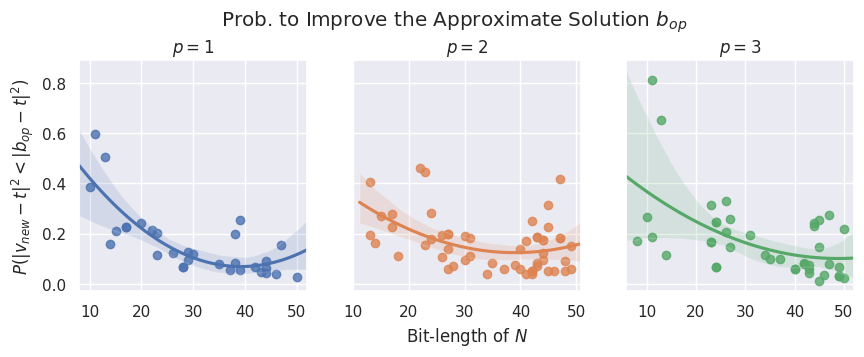

In [288]:
# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# Read data.
data_1 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-independent-training.csv').drop(columns=['Unnamed: 0'])
data_2 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=2)-independent-training.csv').drop(columns=['Unnamed: 0'])
data_3 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=3)-independent-training.csv').drop(columns=['Unnamed: 0'])

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

# Add 'exact' lattice dimension onto it (so we can differentiate points more easily).
data_1['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_1['N'], data_1['l'])
]
data_2['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_2['N'], data_2['l'])
]
data_3['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_3['N'], data_3['l'])
]

# Drop all failing points (for now).
successful_only_1 = data_1[data_1['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
successful_only_2 = data_2[data_2['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
successful_only_3 = data_3[data_3['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1, order=2, ax=ax1, truncate=False, color=sns.color_palette(palette, n_colors=3)[0])
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2, order=2, ax=ax2, truncate=False, color=sns.color_palette(palette, n_colors=3)[1])
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3, order=2, ax=ax3, truncate=False, color=sns.color_palette(palette, n_colors=3)[2])

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=51, step=10))
ax2.set_xticks(np.arange(start=10, stop=51, step=10))
ax3.set_xticks(np.arange(start=10, stop=51, step=10))

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(sharey-by-p).pdf', bbox_inches='tight')

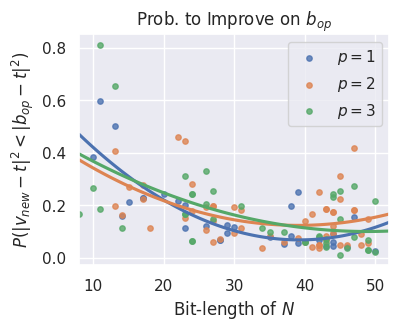

In [120]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

ax.set_title('Prob. to Improve on $b_{op}$')

marker_size = 15
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1, order=2, ax=ax, truncate=False, label='$p=1$', ci=False, scatter_kws={'s':marker_size})
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2, order=2, ax=ax, truncate=False, label='$p=2$', ci=False, scatter_kws={'s':marker_size})
sns.regplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3, order=2, ax=ax, truncate=False, label='$p=3$', ci=False, scatter_kws={'s':marker_size})

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')
ax.legend()

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(hued-by-p).pdf', bbox_inches='tight')

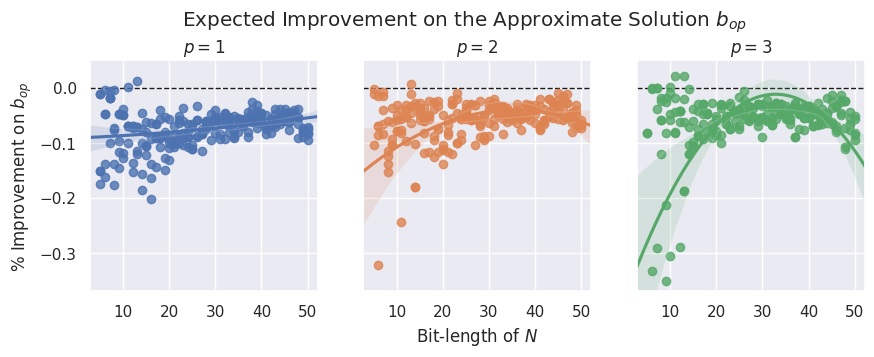

In [165]:
# Compute the expected change in distance to the target vector.
data_1['Expected Improvement'] = (data_1['|b_op - t|^2'] - data_1['E[|v_new - t|^2]']) / data_1['|b_op - t|^2']
data_2['Expected Improvement'] = (data_2['|b_op - t|^2'] - data_2['E[|v_new - t|^2]']) / data_2['|b_op - t|^2']
data_3['Expected Improvement'] = (data_3['|b_op - t|^2'] - data_3['E[|v_new - t|^2]']) / data_3['|b_op - t|^2']

# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# It'd be nice to have the boundary between negative and positive improvement highlighted.
ax1.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax2.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax3.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)

sns.regplot(x='Bit-length', y='Expected Improvement', data=data_1, order=2, ax=ax1, truncate=False, color=sns.color_palette(palette, n_colors=3)[0])
sns.regplot(x='Bit-length', y='Expected Improvement', data=data_2, order=2, ax=ax2, truncate=False, color=sns.color_palette(palette, n_colors=3)[1])
sns.regplot(x='Bit-length', y='Expected Improvement', data=data_3, order=2, ax=ax3, truncate=False, color=sns.color_palette(palette, n_colors=3)[2])

fig.suptitle('Expected Improvement on the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('% Improvement on $b_{op}$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=51, step=10))
ax2.set_xticks(np.arange(start=10, stop=51, step=10))
ax3.set_xticks(np.arange(start=10, stop=51, step=10))

ax1.set_ylim(-0.37, 0.05)

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(sharey-by-p).pdf', bbox_inches='tight')

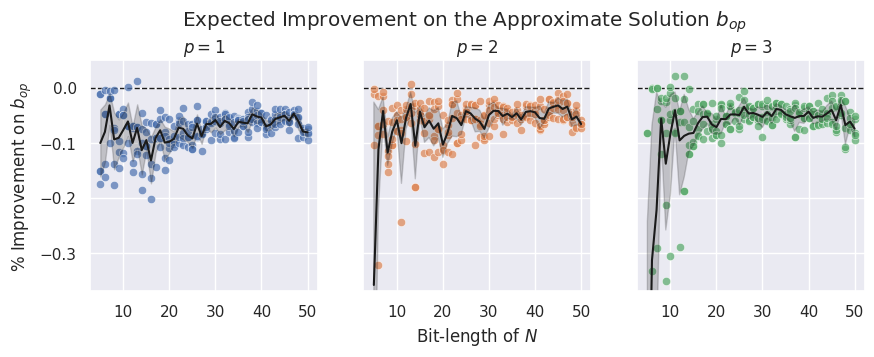

In [180]:
# Compute the expected change in distance to the target vector.
data_1['Expected Improvement'] = (data_1['|b_op - t|^2'] - data_1['E[|v_new - t|^2]']) / data_1['|b_op - t|^2']
data_2['Expected Improvement'] = (data_2['|b_op - t|^2'] - data_2['E[|v_new - t|^2]']) / data_2['|b_op - t|^2']
data_3['Expected Improvement'] = (data_3['|b_op - t|^2'] - data_3['E[|v_new - t|^2]']) / data_3['|b_op - t|^2']

# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# It'd be nice to have the boundary between negative and positive improvement highlighted.
ax1.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax2.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax3.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)

sns.scatterplot(x='Bit-length', y='Expected Improvement', data=data_1, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0], alpha=.7)
sns.scatterplot(x='Bit-length', y='Expected Improvement', data=data_2, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1], alpha=.7)
sns.scatterplot(x='Bit-length', y='Expected Improvement', data=data_3, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2], alpha=.7)

sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_1, ax=ax1, color='k')
sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_2, ax=ax2, color='k')
sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_3, ax=ax3, color='k')

fig.suptitle('Expected Improvement on the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('% Improvement on $b_{op}$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=51, step=10))
ax2.set_xticks(np.arange(start=10, stop=51, step=10))
ax3.set_xticks(np.arange(start=10, stop=51, step=10))

ax1.set_ylim(-0.37, 0.05)

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(scatter-line).pdf', bbox_inches='tight')

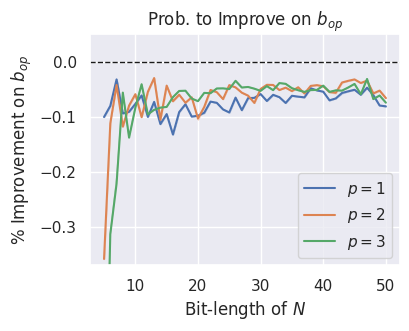

In [194]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

ax.set_title('Expected Improvement on $b_{op}$')

data_1['p'] = ['$p=1$'] * len(data_1)
data_2['p'] = ['$p=2$'] * len(data_2)
data_3['p'] = ['$p=3$'] * len(data_3)

data_all = pd.concat([data_1, data_2, data_3])

sns.lineplot(x='Bit-length', y='Expected Improvement', data=data_all, hue='p', ci=False, palette=palette)

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax.set_ylim(-0.37, 0.05)

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(line-hued-by-p).pdf', bbox_inches='tight')

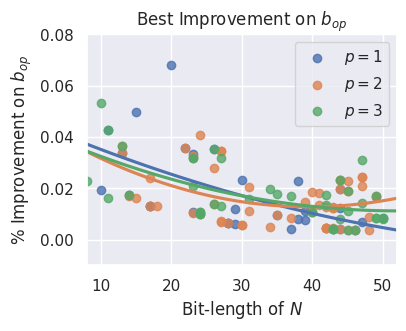

In [219]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

# Compute the best change in distance to the target vector.
data_all['Best Improvement'] = (data_all['|b_op - t|^2'] - data_all['|v_best - t|^2']) / data_all['|b_op - t|^2']

# Drop all failing points (for now).
successful_only_all = data_all[data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

sns.regplot(x='Bit-length', y='Best Improvement', data=successful_only_all[successful_only_all['p'] == '$p=1$'], order=2, ax=ax, truncate=False, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$')
sns.regplot(x='Bit-length', y='Best Improvement', data=successful_only_all[successful_only_all['p'] == '$p=2$'], order=2, ax=ax, truncate=False, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$')
sns.regplot(x='Bit-length', y='Best Improvement', data=successful_only_all[successful_only_all['p'] == '$p=3$'], order=2, ax=ax, truncate=False, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$')

ax.set_title('Best Improvement on $b_{op}$')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.set_ylim(-.01, 0.08)

plt.savefig('./figures/qaoa-based-independent-training/best-improvement-(hued-by-p).pdf', bbox_inches='tight')

We'll now fit these data to the curve $y=1/2^{\alpha x}$ by minimising this sum of the squared residuals with an optimal choice for $\alpha$. This gives us a measure for the scaling of $y$ with respect to $x$, assuming it scales exponentially.

We are most interested in whether the SQIF algorithm can improve the approximate solution to the CVP in such a way that it scales effectively as the lattice dimension increases. In particular, if we can fit the curve with $\alpha<1$, then the scaling is not exponential as suspected.

In [297]:
# Define the x- and y-data.
x_data_successful_1 = successful_only_1['Bit-length']
y_data_successful_1 = successful_only_1['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_successful_2 = successful_only_2['Bit-length']
y_data_successful_2 = successful_only_2['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_successful_3 = successful_only_3['Bit-length']
y_data_successful_3 = successful_only_3['P(|v_new - t|^2 < |b_op - t|^2)']

x_data_1 = data_1['Bit-length']
y_data_1 = data_1['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_2 = data_2['Bit-length']
y_data_2 = data_2['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_3 = data_3['Bit-length']
y_data_3 = data_3['P(|v_new - t|^2 < |b_op - t|^2)']

# Fit the curve to find an optimal alpha.
params_successful_1 = curve_fit(scaling_function, x_data_successful_1, y_data_successful_1)[0]
alpha_successful_1 = params_successful_1[0]
params_successful_2 = curve_fit(scaling_function, x_data_successful_2, y_data_successful_2)[0]
alpha_successful_2 = params_successful_2[0]
params_successful_3 = curve_fit(scaling_function, x_data_successful_3, y_data_successful_3)[0]
alpha_successful_3 = params_successful_3[0]

params_1 = curve_fit(scaling_function, x_data_1, y_data_1)[0]
alpha_1 = params_1[0]
params_2 = curve_fit(scaling_function, x_data_2, y_data_2)[0]
alpha_2 = params_2[0]
params_3 = curve_fit(scaling_function, x_data_3, y_data_3)[0]
alpha_3 = params_3[0]

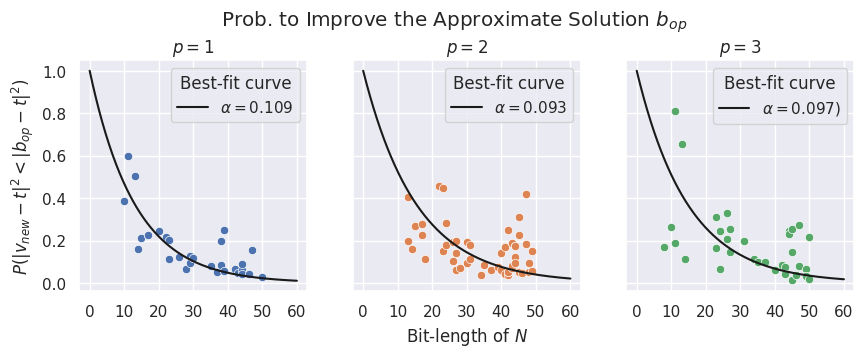

In [301]:
# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# Scatters.
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0])
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1])
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2])

# Fitted curves.
step_size = .1
xs = np.arange(start=0, stop=60+step_size, step=step_size)
ys_successful_1 = [scaling_function(x, alpha_successful_1) for x in xs]
ys_successful_2 = [scaling_function(x, alpha_successful_2) for x in xs]
ys_successful_3 = [scaling_function(x, alpha_successful_3) for x in xs]
#ys_1 = [scaling_function(x, alpha_1) for x in xs]
#ys_2 = [scaling_function(x, alpha_2) for x in xs]
#ys_3 = [scaling_function(x, alpha_3) for x in xs]

sns.lineplot(x=xs, y=ys_successful_1, color='k', ax=ax1, label=f'$\\alpha={alpha_successful_1:.3f}$')
sns.lineplot(x=xs, y=ys_successful_2, color='k', ax=ax2, label=f'$\\alpha={alpha_successful_2:.3f}$')
sns.lineplot(x=xs, y=ys_successful_3, color='k', ax=ax3, label=f'$\\alpha={alpha_successful_3:.3f}$)')
#sns.lineplot(x=xs, y=ys_1, color='k', ax=ax1, linestyle='--', label=f'$\\alpha={alpha_1:.3f}$')
#sns.lineplot(x=xs, y=ys_2, color='k', ax=ax2, linestyle='--', label=f'$\\alpha={alpha_2:.3f}$')
#sns.lineplot(x=xs, y=ys_3, color='k', ax=ax3, linestyle='--', label=f'$\\alpha={alpha_3:.3f}$')

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=0, stop=61, step=10))
ax2.set_xticks(np.arange(start=0, stop=61, step=10))
ax3.set_xticks(np.arange(start=0, stop=61, step=10))

ax1.legend(title='Best-fit curve')
ax2.legend(title='Best-fit curve')
ax3.legend(title='Best-fit curve')

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-fit-curves-(sharey-by-p).pdf', bbox_inches='tight')

Using the larger datasets to improve the accuracy of our figures and analyses.

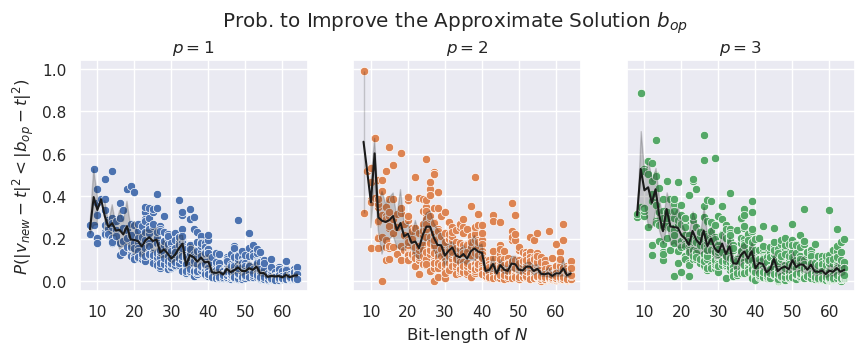

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

data_1_large = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-independent-training-large.csv').drop(columns='Unnamed: 0')
data_2_large = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=2)-independent-training-large.csv').drop(columns='Unnamed: 0')
data_3_large = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=3)-independent-training-large.csv').drop(columns='Unnamed: 0')

successful_only_1_large = data_1_large[data_1_large['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
successful_only_2_large = data_2_large[data_2_large['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
successful_only_3_large = data_3_large[data_3_large['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0])
sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax1, color='k')

sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2_large, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1])
sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2_large, ax=ax2, color='k')

sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3_large, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2])
sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3_large, ax=ax3, color='k')

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=10, stop=65, step=10))
ax2.set_xticks(np.arange(start=10, stop=65, step=10))
ax3.set_xticks(np.arange(start=10, stop=65, step=10))

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(sharey-by-p)-large.pdf', bbox_inches='tight')

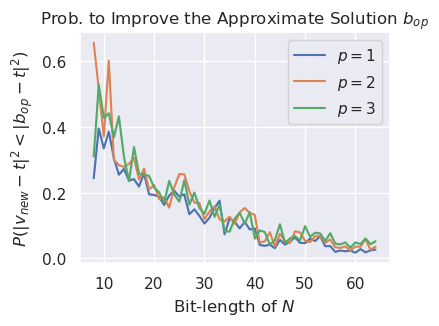

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$')
sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$')
sns.lineplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$')

ax.set_title('Prob. to Improve the Approximate Solution $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.set_xticks(np.arange(start=10, stop=65, step=10))

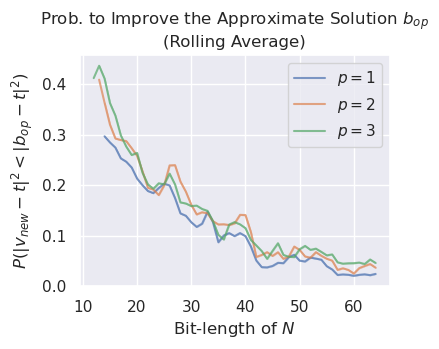

In [30]:
fig, ax = plt.subplots(figsize=(4, 3))

window = 30
sns.lineplot(x=successful_only_1_large['Bit-length'], y=successful_only_1_large['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$', alpha=.7)
sns.lineplot(x=successful_only_2_large['Bit-length'], y=successful_only_2_large['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$', alpha=.7)
sns.lineplot(x=successful_only_3_large['Bit-length'], y=successful_only_3_large['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$', alpha=.7)

ax.set_title('Prob. to Improve the Approximate Solution $b_{op}$\n(Rolling Average)')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.set_xticks(np.arange(start=10, stop=65, step=10))

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-rolling-average-(hue-by-p)-large.pdf', bbox_inches='tight')

In [5]:
x_data_successful_1_large = successful_only_1_large['Bit-length']
y_data_successful_1_large = successful_only_1_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_1_large = data_1_large['Bit-length']
y_data_1_large = data_1_large['P(|v_new - t|^2 < |b_op - t|^2)']

x_data_successful_2_large = successful_only_2_large['Bit-length']
y_data_successful_2_large = successful_only_2_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_2_large = data_2_large['Bit-length']
y_data_2_large = data_2_large['P(|v_new - t|^2 < |b_op - t|^2)']

x_data_successful_3_large = successful_only_3_large['Bit-length']
y_data_successful_3_large = successful_only_3_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_3_large = data_3_large['Bit-length']
y_data_3_large = data_3_large['P(|v_new - t|^2 < |b_op - t|^2)']

params_successful_1_large = curve_fit(scaling_function, x_data_successful_1_large, y_data_successful_1_large)[0]
alpha_successful_1_large = params_successful_1_large[0]
params_successful_2_large = curve_fit(scaling_function, x_data_successful_2_large, y_data_successful_2_large)[0]
alpha_successful_2_large = params_successful_2_large[0]
params_successful_3_large = curve_fit(scaling_function, x_data_successful_3_large, y_data_successful_3_large)[0]
alpha_successful_3_large = params_successful_3_large[0]

params_1_large = curve_fit(scaling_function, x_data_1_large, y_data_1_large)[0]
alpha_1_large = params_1_large[0]
params_2_large = curve_fit(scaling_function, x_data_2_large, y_data_2_large)[0]
alpha_2_large = params_2_large[0]
params_3_large = curve_fit(scaling_function, x_data_3_large, y_data_3_large)[0]
alpha_3_large = params_3_large[0]

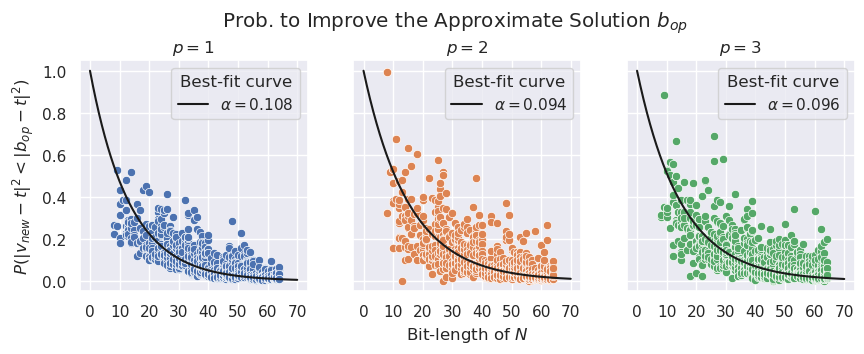

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0])
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2_large, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1])
sns.scatterplot(x='Bit-length', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3_large, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2])

# Fitted curves.
step_size = .1
xs_large = np.arange(start=0, stop=70+step_size, step=step_size)
ys_successful_1_large = [scaling_function(x, alpha_successful_1_large) for x in xs_large]
ys_successful_2_large = [scaling_function(x, alpha_successful_2_large) for x in xs_large]
ys_successful_3_large = [scaling_function(x, alpha_successful_3_large) for x in xs_large]
#ys_1 = [scaling_function(x, alpha_1) for x in xs]

sns.lineplot(x=xs_large, y=ys_successful_1_large, color='k', ax=ax1, label=f'$\\alpha={alpha_successful_1_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_successful_2_large, color='k', ax=ax2, label=f'$\\alpha={alpha_successful_2_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_successful_3_large, color='k', ax=ax3, label=f'$\\alpha={alpha_successful_3_large:.3f}$')
#sns.lineplot(x=xs, y=ys_3, color='k', ax=ax3, linestyle='--', label=f'$\\alpha={alpha_3:.3f}$')

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Bit-length of $N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=0, stop=75, step=10))
ax2.set_xticks(np.arange(start=0, stop=75, step=10))
ax3.set_xticks(np.arange(start=0, stop=75, step=10))

ax1.legend(title='Best-fit curve')
ax2.legend(title='Best-fit curve')
ax3.legend(title='Best-fit curve')

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-fit-curves-(sharey-by-p)-large.pdf', bbox_inches='tight')

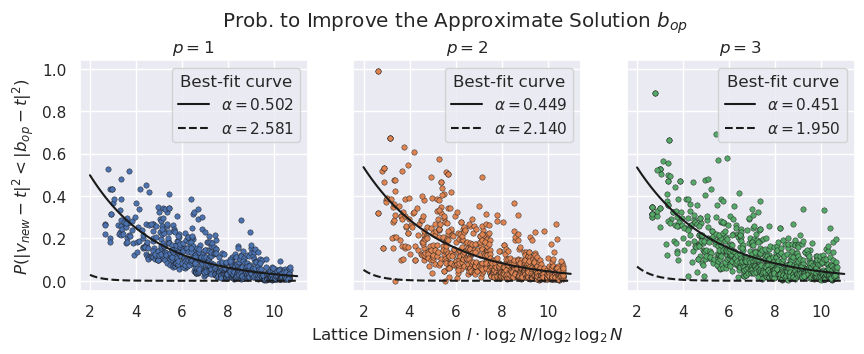

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))
successful_only_1_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(successful_only_1_large['N'], successful_only_1_large['l'])
]
successful_only_2_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(successful_only_2_large['N'], successful_only_2_large['l'])
]
successful_only_3_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(successful_only_3_large['N'], successful_only_3_large['l'])
]
data_1_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_1_large['N'], data_1_large['l'])
]
data_2_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_2_large['N'], data_2_large['l'])
]
data_3_large['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(data_3_large['N'], data_3_large['l'])
]

sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_1_large, ax=ax1, color=sns.color_palette(palette, n_colors=3)[0], s=15, edgecolor='k')
sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_2_large, ax=ax2, color=sns.color_palette(palette, n_colors=3)[1], s=15, edgecolor='k')
sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=successful_only_3_large, ax=ax3, color=sns.color_palette(palette, n_colors=3)[2], s=15, edgecolor='k')

x_data_successful_1_large = successful_only_1_large['Exact Lattice Dimension']
y_data_successful_1_large = successful_only_1_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_successful_2_large = successful_only_2_large['Exact Lattice Dimension']
y_data_successful_2_large = successful_only_2_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_successful_3_large = successful_only_3_large['Exact Lattice Dimension']
y_data_successful_3_large = successful_only_3_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_1_large = data_1_large['Exact Lattice Dimension']
y_data_1_large = data_1_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_2_large = data_2_large['Exact Lattice Dimension']
y_data_2_large = data_2_large['P(|v_new - t|^2 < |b_op - t|^2)']
x_data_3_large = data_3_large['Exact Lattice Dimension']
y_data_3_large = data_3_large['P(|v_new - t|^2 < |b_op - t|^2)']

params_successful_1_large = curve_fit(scaling_function, x_data_successful_1_large, y_data_successful_1_large)[0]
alpha_successful_1_large = params_successful_1_large[0]
params_successful_2_large = curve_fit(scaling_function, x_data_successful_2_large, y_data_successful_2_large)[0]
alpha_successful_2_large = params_successful_2_large[0]
params_successful_3_large = curve_fit(scaling_function, x_data_successful_3_large, y_data_successful_3_large)[0]
alpha_successful_3_large = params_successful_3_large[0]
params_1_large = curve_fit(scaling_function, x_data_1_large, y_data_1_large)[0]
alpha_1_large = params_1_large[0]
params_2_large = curve_fit(scaling_function, x_data_2_large, y_data_2_large)[0]
alpha_2_large = params_2_large[0]
params_3_large = curve_fit(scaling_function, x_data_3_large, y_data_3_large)[0]
alpha_3_large = params_3_large[0]

step_size = .1
xs_large = np.arange(start=2, stop=11+step_size, step=step_size)
ys_successful_1_large = [scaling_function(x, alpha_successful_1_large) for x in xs_large]
ys_successful_2_large = [scaling_function(x, alpha_successful_2_large) for x in xs_large]
ys_successful_3_large = [scaling_function(x, alpha_successful_3_large) for x in xs_large]
ys_1_large = [scaling_function(x, alpha_1_large) for x in xs_large]
ys_2_large = [scaling_function(x, alpha_2_large) for x in xs_large]
ys_3_large = [scaling_function(x, alpha_3_large) for x in xs_large]

sns.lineplot(x=xs_large, y=ys_successful_1_large, color='k', ax=ax1, label=f'$\\alpha={alpha_successful_1_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_successful_2_large, color='k', ax=ax2, label=f'$\\alpha={alpha_successful_2_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_successful_3_large, color='k', ax=ax3, label=f'$\\alpha={alpha_successful_3_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_1_large, color='k', ax=ax1, linestyle='--', label=f'$\\alpha={alpha_1_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_2_large, color='k', ax=ax2, linestyle='--', label=f'$\\alpha={alpha_2_large:.3f}$')
sns.lineplot(x=xs_large, y=ys_3_large, color='k', ax=ax3, linestyle='--', label=f'$\\alpha={alpha_3_large:.3f}$')

fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=2, stop=11, step=2))
ax2.set_xticks(np.arange(start=2, stop=11, step=2))
ax3.set_xticks(np.arange(start=2, stop=11, step=2))

ax1.legend(title='Best-fit curve')
ax2.legend(title='Best-fit curve')
ax3.legend(title='Best-fit curve')

plt.savefig('./figures/qaoa-based-independent-training/prob-to-improve-approx-(wrt-lattice-dim)-fit-curves-(sharey-by-p)-large.pdf', bbox_inches='tight')

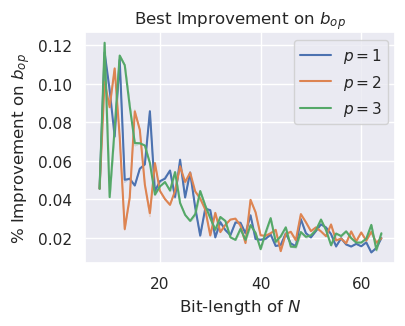

In [12]:
# Chucking the above into a single scatterplot, hued by QAOA-depth.
fig, ax = plt.subplots(figsize=(4, 3))

# Compute the best change in distance to the target vector.
successful_only_1_large['Best Improvement'] = (successful_only_1_large['|b_op - t|^2'] - successful_only_1_large['|v_best - t|^2']) / successful_only_1_large['|b_op - t|^2']
successful_only_2_large['Best Improvement'] = (successful_only_2_large['|b_op - t|^2'] - successful_only_2_large['|v_best - t|^2']) / successful_only_2_large['|b_op - t|^2']
successful_only_3_large['Best Improvement'] = (successful_only_3_large['|b_op - t|^2'] - successful_only_3_large['|v_best - t|^2']) / successful_only_3_large['|b_op - t|^2']
data_1_large['Best Improvement'] = (data_1_large['|b_op - t|^2'] - data_1_large['|v_best - t|^2']) / data_1_large['|b_op - t|^2']
data_2_large['Best Improvement'] = (data_2_large['|b_op - t|^2'] - data_2_large['|v_best - t|^2']) / data_2_large['|b_op - t|^2']
data_3_large['Best Improvement'] = (data_3_large['|b_op - t|^2'] - data_3_large['|v_best - t|^2']) / data_3_large['|b_op - t|^2']

sns.lineplot(x='Bit-length', y='Best Improvement', data=successful_only_1_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$')
sns.lineplot(x='Bit-length', y='Best Improvement', data=successful_only_2_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$')
sns.lineplot(x='Bit-length', y='Best Improvement', data=successful_only_3_large, ax=ax, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$')

ax.set_title('Best Improvement on $b_{op}$')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

#ax.set_ylim(-.01, 0.08)

plt.savefig('./figures/qaoa-based-independent-training/best-improvement-(hued-by-p)-large.pdf', bbox_inches='tight')

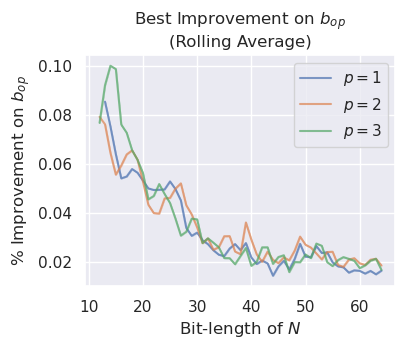

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))

window = 25
sns.lineplot(x=successful_only_1_large['Bit-length'], y=successful_only_1_large['Best Improvement'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$', alpha=.7)
sns.lineplot(x=successful_only_2_large['Bit-length'], y=successful_only_2_large['Best Improvement'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$', alpha=.7)
sns.lineplot(x=successful_only_3_large['Bit-length'], y=successful_only_3_large['Best Improvement'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$', alpha=.7)

ax.set_title('Best Improvement on $b_{op}$\n(Rolling Average)')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Bit-length of $N$')

ax.legend()

ax.set_xticks(np.arange(start=10, stop=65, step=10))

plt.savefig('./figures/qaoa-based-independent-training/best-improvement-rolling-average-(hued-by-p)-large.pdf', bbox_inches='tight')

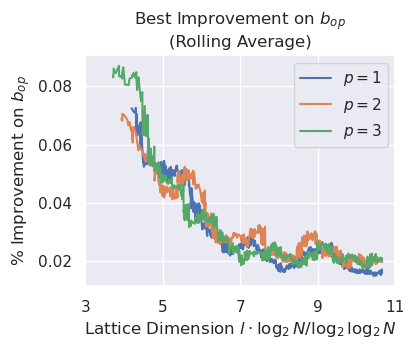

In [78]:
fig, ax = plt.subplots(figsize=(4, 3))

window = 50
sns.lineplot(x=successful_only_1_large['Exact Lattice Dimension'], y=successful_only_1_large['Best Improvement'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[0], ci=False, label='$p=1$')
sns.lineplot(x=successful_only_2_large['Exact Lattice Dimension'], y=successful_only_2_large['Best Improvement'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[1], ci=False, label='$p=2$')
sns.lineplot(x=successful_only_3_large['Exact Lattice Dimension'], y=successful_only_3_large['Best Improvement'].rolling(window=window).mean(), ax=ax, color=sns.color_palette(palette, n_colors=3)[2], ci=False, label='$p=3$')

ax.set_title('Best Improvement on $b_{op}$\n(Rolling Average)')
ax.set_ylabel('% Improvement on $b_{op}$')
ax.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')

ax.legend()

ax.set_xticks(np.arange(start=3, stop=12, step=2))

plt.savefig('./figures/qaoa-based-independent-training/best-improvement-rolling-average-(hued-by-p)-large.pdf', bbox_inches='tight')

In [36]:
data_1_large['Expected Improvement'] = (data_1_large['|b_op - t|^2'] - data_1_large['E[|v_new - t|^2]']) / data_1_large['|b_op - t|^2']
data_2_large['Expected Improvement'] = (data_2_large['|b_op - t|^2'] - data_2_large['E[|v_new - t|^2]']) / data_2_large['|b_op - t|^2']
data_3_large['Expected Improvement'] = (data_3_large['|b_op - t|^2'] - data_3_large['E[|v_new - t|^2]']) / data_3_large['|b_op - t|^2']
successful_only_1_large['Expected Improvement'] = (successful_only_1_large['|b_op - t|^2'] - successful_only_1_large['E[|v_new - t|^2]']) / successful_only_1_large['|b_op - t|^2']
successful_only_2_large['Expected Improvement'] = (successful_only_2_large['|b_op - t|^2'] - successful_only_2_large['E[|v_new - t|^2]']) / successful_only_2_large['|b_op - t|^2']
successful_only_3_large['Expected Improvement'] = (successful_only_3_large['|b_op - t|^2'] - successful_only_3_large['E[|v_new - t|^2]']) / successful_only_3_large['|b_op - t|^2']

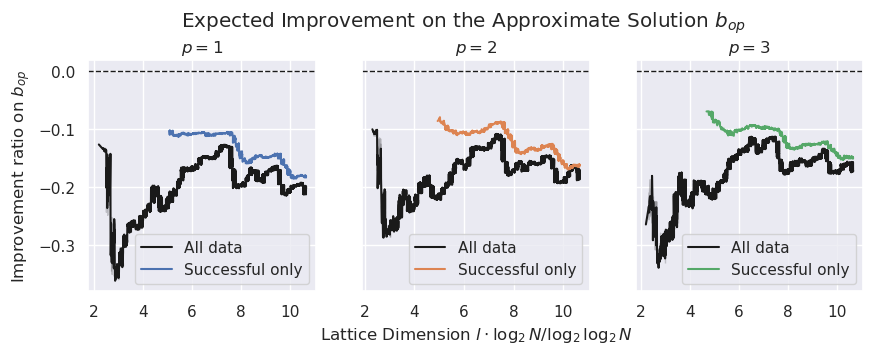

In [77]:
# Set up the figure.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

# It'd be nice to have the boundary between negative and positive improvement highlighted.
ax1.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax2.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)
ax3.axhline(0, color='k', linewidth=1, linestyle='--', zorder=1)

window = 100
sns.lineplot(x=data_1_large['Exact Lattice Dimension'], y=data_1_large['Expected Improvement'].rolling(window=window).mean(), ax=ax1, color='k', linestyle='-', label='All data')
sns.lineplot(x=data_2_large['Exact Lattice Dimension'], y=data_2_large['Expected Improvement'].rolling(window=window).mean(), ax=ax2, color='k', linestyle='-', label='All data')
sns.lineplot(x=data_3_large['Exact Lattice Dimension'], y=data_3_large['Expected Improvement'].rolling(window=window).mean(), ax=ax3, color='k', linestyle='-', label='All data')

sns.lineplot(x=successful_only_1_large['Exact Lattice Dimension'], y=successful_only_1_large['Expected Improvement'].rolling(window=window).mean(), ax=ax1, color=sns.color_palette(palette, n_colors=3)[0], linestyle='-', label='Successful only')
sns.lineplot(x=successful_only_2_large['Exact Lattice Dimension'], y=successful_only_2_large['Expected Improvement'].rolling(window=window).mean(), ax=ax2, color=sns.color_palette(palette, n_colors=3)[1], linestyle='-', label='Successful only')
sns.lineplot(x=successful_only_3_large['Exact Lattice Dimension'], y=successful_only_3_large['Expected Improvement'].rolling(window=window).mean(), ax=ax3, color=sns.color_palette(palette, n_colors=3)[2], linestyle='-', label='Successful only')


fig.suptitle('Expected Improvement on the Approximate Solution $b_{op}$', y=1.05)

ax1.set_title('$p=1$')
ax2.set_title('$p=2$')
ax3.set_title('$p=3$')

ax1.set_ylabel('Improvement ratio on $b_{op}$')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.set_xlabel('')
ax2.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')
ax3.set_xlabel('')

ax1.set_xticks(np.arange(start=2, stop=12, step=2))
ax2.set_xticks(np.arange(start=2, stop=12, step=2))
ax3.set_xticks(np.arange(start=2, stop=12, step=2))

ax2.legend(loc='lower right')

#ax1.set_yticks(np.arange(start=-.05, stop=-.41, step=-.05))

plt.savefig('./figures/qaoa-based-independent-training/expected-improvement-(sharey-by-p)-large.pdf', bbox_inches='tight')

### QAOA-based, Pre-training

Now we explore the idea from [Boulebnane and Montanaro (2022)](https://arxiv.org/pdf/2208.06909.pdf) that a set of QAOA parameters $\{(\gamma_p,\beta_p)\}_{p=1,2,\dots}$ can be obtained by "training" a QAOA circuit for one problem instance, then be used as a good general choice of parameters for other instances -- pre-training, in a sense. This is a weak form of the cross-validation to follow.

Obviously, this won't be as good as independently training each instance, but it should demonstrate the same scaling behaviour, which we can use to generate data more efficiently for an analysis of the higher dimension problem instances.

Understanding the final distribution of $\gamma$ and $\beta$ is a single-layer QAOA for different problem instances.

In [19]:
# For reference, 10 repetitions with 1 sample per run, this takes ~20 min.
parameters_by_bit_length = pd.DataFrame({
    'Bit-length' : [],
    'beta' : [],
    'gamma' : []
})

# For each bit-length...
for n_bits in tqdm(range(4, 65)):
    # Repeat a few times...
    for _ in range(10):
        # Choose a random prime.
        N = number.getPrime(n_bits)
    
        # Set up the CVP.
        cvp = CVP()
        cvp.generate_cvp(N, l=1, c=3, seed=42)
        
        # Solve it!
        _, _, _, param_assignments = solve_cvp(cvp, n_samples=1, delta=.75, p=1, min_method='Nelder-Mead', verbose=False)
        
        # Make note of the QAOA parameter assignments.
        experiment_outcome = pd.DataFrame({
            'Bit-length' : [n_bits], 
            'beta' : [param_assignments.param_dict['beta_0']],
            'gamma' : [param_assignments.param_dict['gamma_0']]
        })
        
        parameters_by_bit_length = pd.concat([parameters_by_bit_length, experiment_outcome])
        
parameters_by_bit_length.to_csv('./results/quantum-accelerated-cvp/qaoa-parameters-by-bit-length.csv')

  0%|          | 0/61 [00:00<?, ?it/s]

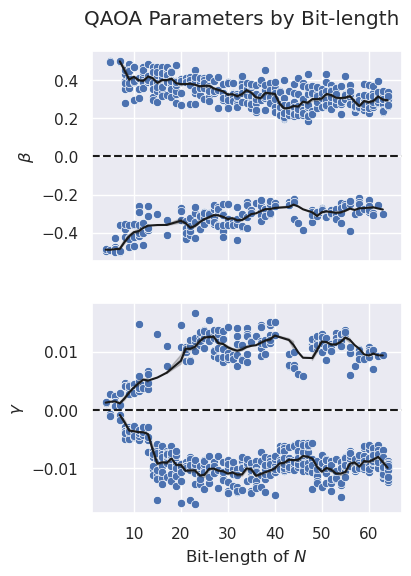

In [43]:
# Read in that data.
parameters_by_bit_length = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-parameters-by-bit-length.csv').drop(columns=['Unnamed: 0'])
parameters_by_bit_length

# Plot gamma and beta by bit-length.
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharex='all', figsize=(4, 6))

sns.scatterplot(x='Bit-length', y='beta', data=parameters_by_bit_length, ax=ax1)
sns.scatterplot(x='Bit-length', y='gamma', data=parameters_by_bit_length, ax=ax2)

# Split the line plots into a positive and negative variant (because a single line plot is going to be pretty uninformative).
positive_beta = parameters_by_bit_length[parameters_by_bit_length['beta'] > 0]
negative_beta = parameters_by_bit_length[parameters_by_bit_length['beta'] < 0]
positive_gamma = parameters_by_bit_length[parameters_by_bit_length['gamma'] > 0]
negative_gamma = parameters_by_bit_length[parameters_by_bit_length['gamma'] < 0]

window=10
sns.lineplot(x=positive_beta['Bit-length'], y=positive_beta['beta'].rolling(window).mean(), ax=ax1, color='k')
sns.lineplot(x=negative_beta['Bit-length'], y=negative_beta['beta'].rolling(window).mean(), ax=ax1, color='k')
sns.lineplot(x=positive_gamma['Bit-length'], y=positive_gamma['gamma'].rolling(window).mean(), ax=ax2, color='k')
sns.lineplot(x=negative_gamma['Bit-length'], y=negative_gamma['gamma'].rolling(window).mean(), ax=ax2, color='k')

fig.suptitle('QAOA Parameters by Bit-length', y=.95)
ax1.set_ylabel('$\\beta$')
ax2.set_ylabel('$\\gamma$')
ax2.set_xlabel('Bit-length of $N$')

ax1.axhline(0, linestyle='--', color='k')
ax2.axhline(0, linestyle='--', color='k')

ax2.set_xticks(np.arange(start=10, stop=65, step=10))

plt.savefig('./figures/qaoa-parameters-by-bit-length.pdf', bbox_inches='tight')

Pre-training assignments to $\{(\gamma_p,\beta_p)\}_{p=1,2,\dots}$ on different sized problem instances (i.e. on differing bit-lengths).

In [5]:
def from_parameters_qaoa_experiment(n_bits, parameters, l, c, seed=42, n_samples=1000, delta=.75, p=1):
    N = number.getPrime(n_bits)
    
    # Set up the CVP.
    cvp = CVP()
    cvp.generate_cvp(N, l=l, c=c, seed=seed)
    
    # Solve it!
    solutions, probabilities, approximate_solution, _ = solve_cvp(cvp, n_samples=n_samples, delta=delta, p=p, min_method='Nelder-Mead', optimal_parameters=parameters, verbose=False)
    
    approximate_quality = np.linalg.norm(approximate_solution - cvp.t)
    
    # Determine the quality of the SQIF algorithm's solutions to the CVP (in terms of probability).
    
    # First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
    best_dist_to_target = np.inf
    best_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < best_dist_to_target:
            best_dist_to_target = dist_to_target
            best_prob = prob
    
    # The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
    better_cum_prob = 0
    worse_cum_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < approximate_quality:
            better_cum_prob += prob
        elif dist_to_target > approximate_quality:
            worse_cum_prob += prob
            
    return pd.DataFrame(
        {
            'Bit-length' : [N.bit_length()],
            'Lattice Dimension' : [cvp.m],
            'N' : [N],
            'l' : [l],
            'c' : [c],
            '|b_op - t|^2' : [approximate_quality],
            'P(b_op)' : [1 - (better_cum_prob + worse_cum_prob)],
            '|v_best - t|^2' : [best_dist_to_target],
            'P(v_best)' : [best_prob],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [better_cum_prob],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [worse_cum_prob],
            'E[|v_new - t|^2]' : [expected_dist(solutions, probabilities, cvp.t)]
        }
    )

N = number.getPrime(30)

# Set up the CVP.
cvp = CVP()
cvp.generate_cvp(N, l=1, c=3, seed=42)

# Solve it!
_, _, _, param_assignments = solve_cvp(cvp, n_samples=1, verbose=False)

from_parameters_qaoa_experiment(11, param_assignments, l=1, c=3)

,Bit-length,Lattice Dimension,N,l,c,|b_op - t|^2,P(b_op),|v_best - t|^2,P(v_best),P(|v_new - t|^2 < |b_op - t|^2),P(|v_new - t|^2 > |b_op - t|^2),E[|v_new - t|^2]
0,11,3,1889,1,3,11.532563,0.3,11.532563,0.3,0,0.7,14.259856


In [8]:
results = give_me_a_blank_results_dataframe()

# Add a column to the results indicating the pretrained value.
results['Pre-training Bit-length'] = []

# Pre-training instance sizes.
# For reference, 50 repeats for n_bits up to 64 takes ~2 min (wow!)
for pretrain_bit_size in [10, 20, 30, 40, 50, 60]:
    # Pre-train to obtain parameter values.
    cvp = CVP()
    cvp.generate_cvp(number.getPrime(pretrain_bit_size), l=1, c=3, seed=42)
    _, _, _, param_assignments = solve_cvp(cvp, n_samples=1, p=1, verbose=False)
    
    # Do a full experiment run as before with pre-trained values.
    for n_bits in tqdm(range(4, 65)):
        # Repeating.
        for _ in range(50):
            experiment_outcome = from_parameters_qaoa_experiment(n_bits, param_assignments, l=1, c=3, seed=42, n_samples=1000, delta=.75, p=1)
            experiment_outcome['Pre-training Bit-length'] = [pretrain_bit_size]
            results = pd.concat([results, experiment_outcome])
        
results.to_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-pretraining-large.csv')

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [9]:
# Read in the data.
pretrain_data_1 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-pretraining-large.csv').drop(columns=['Unnamed: 0'])

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

# Add 'exact' lattice dimension onto it (so we can differentiate points more easily).
pretrain_data_1['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(pretrain_data_1['N'], pretrain_data_1['l'])
]

Text(0.5, 0, 'Bit-length of $N$')

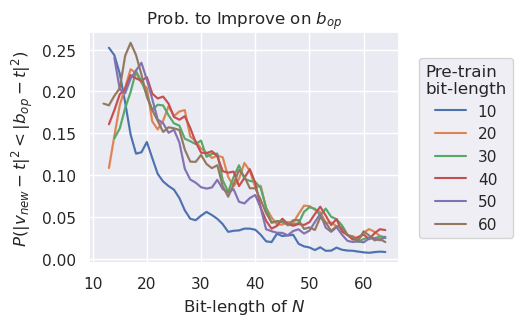

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Filter for the successful data.
pretrain_successful_1 = pretrain_data_1[pretrain_data_1['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Group by pre-training bit-length.
grouped_by_pretrain_length = pretrain_successful_1.groupby('Pre-training Bit-length')
group_counts = grouped_by_pretrain_length.count()

window=25
for i, group_index in enumerate(list(group_counts.index)):
    group_data = grouped_by_pretrain_length.get_group(group_index)
    
    sns.lineplot(x=group_data['Bit-length'], y=group_data['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window).mean(), ci=False, color=sns.color_palette(palette, n_colors=len(group_counts))[i], ax=ax, label=int(group_index))
    
ax.legend(title='Pre-train\nbit-length', bbox_to_anchor=(1.04, 0.5), loc='center left')

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

Using pre-training to extend to extremely large cases.

In [7]:
results = give_me_a_blank_results_dataframe()

# Add a column to the results indicating the pretrained value.
results['Pre-training Bit-length'] = []

# Pre-training instance sizes.
# For reference, 50 repeats for n_bits up to 128 takes ~20 min for each size.
for pretrain_bit_size in tqdm([10, 50, 100]):
    # Pre-train to obtain parameter values.
    cvp = CVP()
    cvp.generate_cvp(number.getPrime(pretrain_bit_size), l=1, c=3, seed=42)
    _, _, _, param_assignments = solve_cvp(cvp, n_samples=1, p=1, verbose=False)
    
    # Do a full experiment run as before with pre-trained values.
    for n_bits in range(4, 128):
        # Repeating.
        for _ in range(50):
            experiment_outcome = from_parameters_qaoa_experiment(n_bits, param_assignments, l=1, c=3, seed=42, n_samples=10000, delta=.75, p=1)
            experiment_outcome['Pre-training Bit-length'] = [pretrain_bit_size]
            results = pd.concat([results, experiment_outcome])
        
results.to_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-pretraining-huge.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# Read in the data.
pretrain_data_1 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=1)-pretraining-huge.csv').drop(columns=['Unnamed: 0'])

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

# Add 'exact' lattice dimension onto it (so we can differentiate points more easily).
pretrain_data_1['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(pretrain_data_1['N'], pretrain_data_1['l'])
]

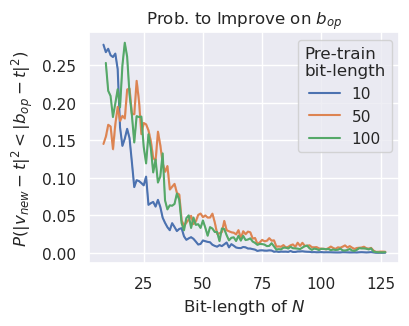

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Filter for the successful data.
pretrain_successful_1 = pretrain_data_1[pretrain_data_1['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Group by pre-training bit-length.
grouped_by_pretrain_length = pretrain_successful_1.groupby('Pre-training Bit-length')
group_counts = grouped_by_pretrain_length.count()

window=10
for i, group_index in enumerate(list(group_counts.index)):
    group_data = grouped_by_pretrain_length.get_group(group_index)
    
    sns.lineplot(x=group_data['Bit-length'], y=group_data['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window).mean(), ci=False, color=sns.color_palette(palette, n_colors=len(group_counts))[i], ax=ax, label=int(group_index))
    
ax.legend(title='Pre-train\nbit-length')

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

plt.savefig('./figures/qaoa-based-pre-training/prob-to-improve-approx-(hued-by-train-length).pdf', bbox_inches='tight')

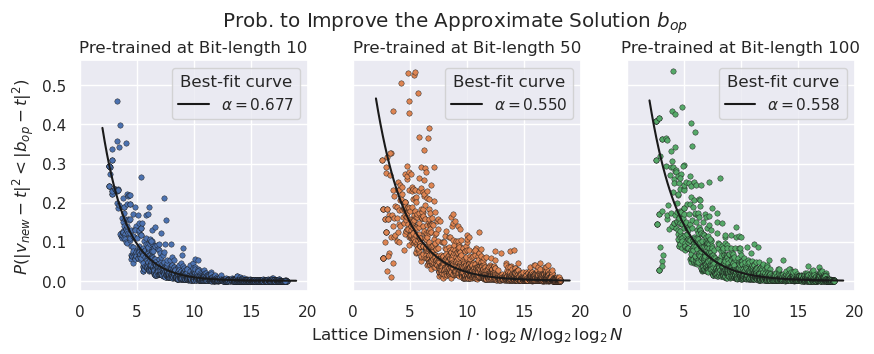

In [22]:
fig, axes = plt.subplots(1, 3, sharey='all', figsize=(10, 3))

for i, group_index in enumerate(list(group_counts.index)):
    # Get the group's data.
    group_data = grouped_by_pretrain_length.get_group(group_index)
    
    # Scatter the points.
    sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=group_data, ax=axes[i], color=sns.color_palette(palette, n_colors=len(group_counts))[i], s=15, edgecolor='k')
    
    # Compute the scaling.
    x_data = group_data['Exact Lattice Dimension']
    y_data = group_data['P(|v_new - t|^2 < |b_op - t|^2)']
    alpha = curve_fit(scaling_function, x_data, y_data)[0][0]
    
    # Generate the curve's points.
    step_size = .1
    xs = np.arange(start=2, stop=19+step_size, step=step_size)
    ys = [scaling_function(x, alpha) for x in xs]
    
    # Plot the scaling curve.
    sns.lineplot(x=xs, y=ys, color='k', ax=axes[i], label=f'$\\alpha={alpha:.3f}$')
    
    axes[i].set_title(f'Pre-trained at Bit-length {int(group_index)}')
    axes[i].set_xticks(np.arange(start=0, stop=21, step=5))
    axes[i].legend(title='Best-fit curve')
    
fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$', y=1.05)


axes[0].set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].set_xlabel('')
axes[1].set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')
axes[2].set_xlabel('')

plt.savefig('./figures/qaoa-based-pre-training/prob-to-improve-approx-(wrt-lattice-dim)-fit-curves-(sharey-by-train-length).pdf', bbox_inches='tight')

Pre-training over different QAOA depths.

In [13]:
import time

# Let's have a quick test of how long it takes for different depths.
# We'll fix the bit-length at something quite easy, like 25, because we're only looking to see how the time scales.
for p in range(1, 11):
    print(f'p = {p}...')
    
    # The pre-training...
    tic = time.perf_counter()
    cvp = CVP()
    cvp.generate_cvp(number.getPrime(25), l=1, c=3, seed=42)
    _, _, _, param_assignments = solve_cvp(cvp, n_samples=1, p=p, verbose=False)
    toc = time.perf_counter()
    print(f'    Pre-training: {toc - tic : .1f} seconds')
    
    # An experiment...
    tic = time.perf_counter()
    from_parameters_qaoa_experiment(25, param_assignments, l=1, c=3, seed=42, n_samples=1000, delta=.75, p=p)
    toc = time.perf_counter()
    print(f'    One experiment run: {toc - tic : .1f} seconds\n')

p = 1...
    Pre-training:  1.4 seconds
    One experiment run:  0.0 seconds

p = 2...
    Pre-training:  7.5 seconds
    One experiment run:  0.0 seconds

p = 3...
    Pre-training:  16.3 seconds
    One experiment run:  0.0 seconds

p = 4...
    Pre-training:  45.8 seconds
    One experiment run:  0.1 seconds

p = 5...
    Pre-training:  57.7 seconds
    One experiment run:  0.1 seconds

p = 6...
    Pre-training:  77.5 seconds
    One experiment run:  0.1 seconds

p = 7...
    Pre-training:  3.0 seconds
    One experiment run:  0.1 seconds

p = 8...
    Pre-training:  166.2 seconds
    One experiment run:  0.1 seconds

p = 9...
    Pre-training:  251.9 seconds
    One experiment run:  0.1 seconds

p = 10...
    Pre-training:  361.8 seconds
    One experiment run:  0.1 seconds


In [15]:
# For reference, p up to 10, pre-train at 25 and 50, bit-lengths up to 128, 50 repetitions each, takes ~11 hours.
for p in tqdm(range(1, 11)):
    results = give_me_a_blank_results_dataframe()

    # Add a column to the results indicating the pretrained value.
    results['Pre-training Bit-length'] = []
    
    for pretrain_bit_size in [25, 50]:
        tic = time.perf_counter()
        
        # Pre-train to obtain parameter values.
        cvp = CVP()
        cvp.generate_cvp(number.getPrime(pretrain_bit_size), l=1, c=3, seed=42)
        _, _, _, param_assignments = solve_cvp(cvp, n_samples=1, p=p, verbose=False)
        
        toc = time.perf_counter()
        print(f'p = {p} pretrained at bit-length {pretrain_bit_size} in {toc - tic : .1f} seconds.')
        
        # Do a full experiment run as before with pre-trained values.
        for n_bits in range(4, 128):
            # Repeating.
            for _ in range(50):
                experiment_outcome = from_parameters_qaoa_experiment(n_bits, param_assignments, l=1, c=3, seed=42, n_samples=10000, delta=.75, p=p)
                experiment_outcome['Pre-training Bit-length'] = [pretrain_bit_size]
                results = pd.concat([results, experiment_outcome])
        
    results.to_csv(f'./results/quantum-accelerated-cvp/qaoa-based-(p={p})-pretraining-huge.csv')

  0%|          | 0/10 [00:00<?, ?it/s]

p = 1 pretrained at bit-length 25 in  1.5 seconds.
p = 1 pretrained at bit-length 50 in  3.1 seconds.
p = 2 pretrained at bit-length 25 in  8.4 seconds.
p = 2 pretrained at bit-length 50 in  20.5 seconds.
p = 3 pretrained at bit-length 25 in  17.9 seconds.
p = 3 pretrained at bit-length 50 in  79.0 seconds.
p = 4 pretrained at bit-length 25 in  50.0 seconds.
p = 4 pretrained at bit-length 50 in  113.6 seconds.
p = 5 pretrained at bit-length 25 in  70.2 seconds.
p = 5 pretrained at bit-length 50 in  122.4 seconds.
p = 6 pretrained at bit-length 25 in  62.6 seconds.
p = 6 pretrained at bit-length 50 in  218.3 seconds.
p = 7 pretrained at bit-length 25 in  152.7 seconds.
p = 7 pretrained at bit-length 50 in  434.1 seconds.
p = 8 pretrained at bit-length 25 in  147.5 seconds.
p = 8 pretrained at bit-length 50 in  394.8 seconds.
p = 9 pretrained at bit-length 25 in  275.9 seconds.
p = 9 pretrained at bit-length 50 in  525.2 seconds.
p = 10 pretrained at bit-length 25 in  350.5 seconds.
p = 

In [5]:
# Read in all that data (214,000 by 13).
pretraining_dataframes = []
for p in range(1, 11):
    df = pd.read_csv(f'./results/quantum-accelerated-cvp/qaoa-based-(p={p})-pretraining-huge.csv').drop(columns=['Unnamed: 0'])
    df['p'] = [p] * len(df)
    pretraining_dataframes.append(df)
    
pretrain_data_all = pd.concat(pretraining_dataframes)

# Choose one of the pre-trained bit-lengths.
pretrain_data_all = pretrain_data_all[pretrain_data_all['Pre-training Bit-length'] == 50]

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

# Add 'exact' lattice dimension onto it (so we can differentiate points more easily).
pretrain_data_all['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(pretrain_data_all['N'], pretrain_data_all['l'])
]

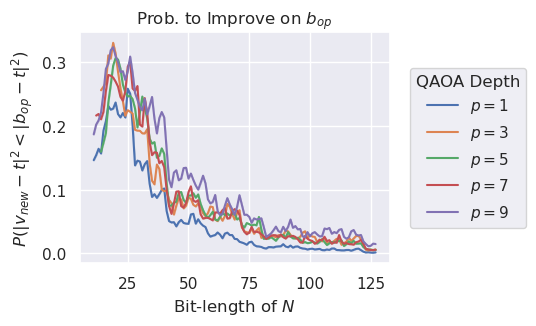

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Filter for the successful data.
pretrain_successful_all = pretrain_data_all[pretrain_data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Group by QAOA depth p.
grouped_by_p = pretrain_successful_all.groupby('p')
group_counts = grouped_by_p.count()

window=25
for i, group_index in enumerate(list(group_counts.index)):
    # Let's only plot the odd p, to reduce clutter in the plot.
    if group_index % 2 == 0: continue
    
    group_data = grouped_by_p.get_group(group_index)
    
    sns.lineplot(x=group_data['Bit-length'], y=group_data['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window).mean(), ci=False, color=sns.color_palette(palette, n_colors=len(group_counts)//2)[(group_index+1)//2-1], ax=ax, label=f'$p={int(group_index)}$')
    
ax.legend(title='QAOA Depth', bbox_to_anchor=(1.04, 0.5), loc='center left')

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

plt.savefig('./figures/qaoa-based-pre-training/prob-to-improve-approx-(hued-by-p).pdf', bbox_inches='tight')

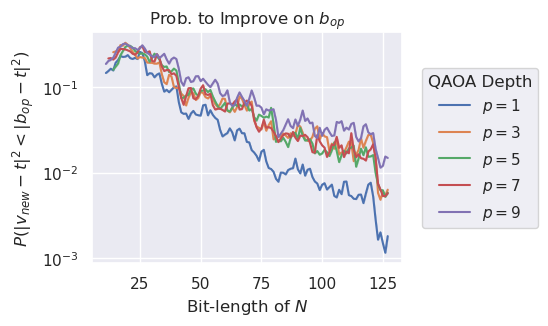

In [107]:
# Giving a logarithmic scale...

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Filter for the successful data.
pretrain_successful_all = pretrain_data_all[pretrain_data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Group by QAOA depth p.
grouped_by_p = pretrain_successful_all.groupby('p')
group_counts = grouped_by_p.count()

window=25
for i, group_index in enumerate(list(group_counts.index)):
    # Let's only plot the odd p, to reduce clutter in the plot.
    if group_index % 2 == 0: continue
    
    group_data = grouped_by_p.get_group(group_index)
    
    sns.lineplot(x=group_data['Bit-length'], y=group_data['P(|v_new - t|^2 < |b_op - t|^2)'].rolling(window).mean(), ci=False, color=sns.color_palette(palette, n_colors=len(group_counts)//2)[(group_index+1)//2-1], ax=ax, label=f'$p={int(group_index)}$')
    
ax.legend(title='QAOA Depth', bbox_to_anchor=(1.04, 0.5), loc='center left')

ax.set_title('Prob. to Improve on $b_{op}$')
ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Bit-length of $N$')

plt.yscale('log')

plt.savefig('./figures/qaoa-based-pre-training/prob-to-improve-approx-(hued-by-p)-(log-scale).pdf', bbox_inches='tight')

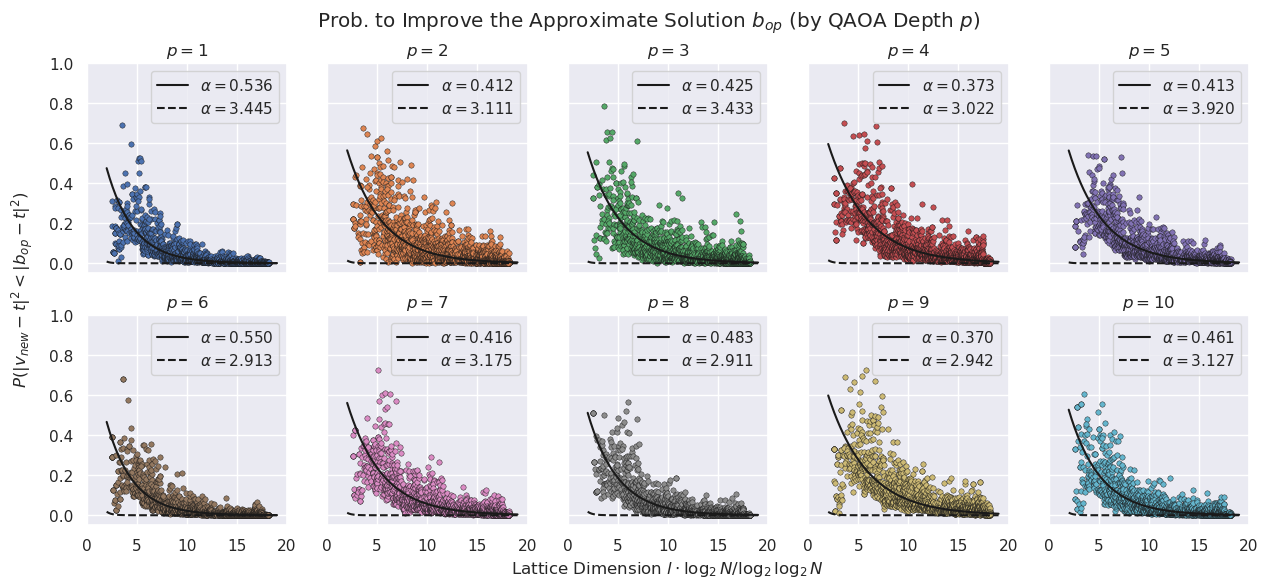

In [16]:
fig, axes = plt.subplots(2, 5, sharey='row', sharex='col', figsize=(15, 6))

# Filter for the successful data.
#pretrain_successful_all = pretrain_data_all[pretrain_data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Group by QAOA depth p (across all data).
grouped_by_p = pretrain_data_all.groupby('p')
group_counts = grouped_by_p.count()

successful_alphas = []
all_alphas = []

for i, group_index in enumerate(list(group_counts.index)):
    # Get the group's data.
    group_data_all = grouped_by_p.get_group(group_index)
    
    # Filter for success.
    group_data = group_data_all[group_data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
    
    # Specify the axis we're working on.
    axis = axes.flatten()[i]
    
    # Scatter the points.
    sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=group_data, ax=axis, color=sns.color_palette(palette, n_colors=len(group_counts))[i], s=15, edgecolor='k')
    
    # Compute the scaling for successful data.
    x_data_successful = group_data['Exact Lattice Dimension']
    y_data_successful = group_data['P(|v_new - t|^2 < |b_op - t|^2)']
    alpha_successful = curve_fit(scaling_function, x_data_successful, y_data_successful)[0][0]
    
    # Compute the scaling for all data.
    x_data_all = group_data_all['Exact Lattice Dimension']
    y_data_all = group_data_all['P(|v_new - t|^2 < |b_op - t|^2)']
    alpha_all = curve_fit(scaling_function, x_data_all, y_data_all)[0][0]
    
    successful_alphas.append(alpha_successful)
    all_alphas.append(alpha_all)
    
    # Generate the curves' points.
    step_size = .1
    xs = np.arange(start=2, stop=19+step_size, step=step_size)
    ys_successful = [scaling_function(x, alpha_successful) for x in xs]
    ys_all = [scaling_function(x, alpha_all) for x in xs]
    
    # Plot the scaling curve.
    sns.lineplot(x=xs, y=ys_successful, color='k', ax=axis, label=f'$\\alpha={alpha_successful:.3f}$')
    sns.lineplot(x=xs, y=ys_all, color='k', linestyle='--', ax=axis, label=f'$\\alpha={alpha_all:.3f}$')
    
    axis.set_title(f'$p={int(group_index)}$')
    axis.set_xticks(np.arange(start=0, stop=21, step=5))
    axis.legend()
    
fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$ (by QAOA Depth $p$)', y=.97)

axes[0][0].set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
axes[0][0].yaxis.set_label_coords(-.25, -.075)
axes[1][0].set_ylabel('')

for axis in axes.flatten():
    axis.set_xlabel('')
    
axes[1][2].set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')

axes[0][0].set_ylim(-.05, 1)
axes[1][0].set_ylim(-.05, 1)

plt.savefig('./figures/qaoa-based-pre-training/prob-to-improve-approx-(wrt-lattice-dim)-fit-curves-(big-by-p).pdf', bbox_inches='tight')

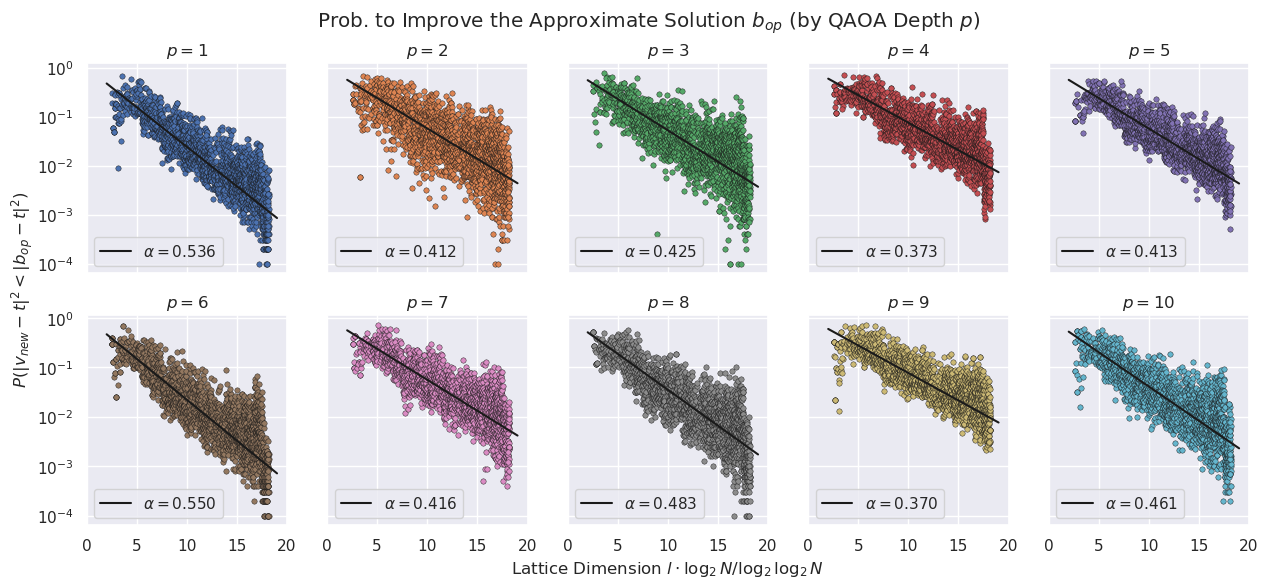

In [15]:
# Again, log scaling.

fig, axes = plt.subplots(2, 5, sharey='row', sharex='col', figsize=(15, 6))

# Filter for the successful data.
#pretrain_successful_all = pretrain_data_all[pretrain_data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Group by QAOA depth p (across all data).
grouped_by_p = pretrain_data_all.groupby('p')
group_counts = grouped_by_p.count()

best_alpha = np.inf
best_axis = None

for i, group_index in enumerate(list(group_counts.index)):
    # Get the group's data.
    group_data_all = grouped_by_p.get_group(group_index)
    
    # Filter for success.
    group_data = group_data_all[group_data_all['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]
    
    # Specify the axis we're working on.
    axis = axes.flatten()[i]
    
    # Scatter the points.
    sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=group_data, ax=axis, color=sns.color_palette(palette, n_colors=len(group_counts))[i], s=15, edgecolor='k')
    
    # Compute the scaling for successful data.
    x_data_successful = group_data['Exact Lattice Dimension']
    y_data_successful = group_data['P(|v_new - t|^2 < |b_op - t|^2)']
    alpha_successful = curve_fit(scaling_function, x_data_successful, y_data_successful)[0][0]
    
    if alpha_successful < best_alpha:
        best_alpha = alpha_successful
        best_axis = axis
    
    # Compute the scaling for all data.
    #x_data_all = group_data_all['Exact Lattice Dimension']
    #y_data_all = group_data_all['P(|v_new - t|^2 < |b_op - t|^2)']
    #alpha_all = curve_fit(scaling_function, x_data_all, y_data_all)[0][0]
    
    # Generate the curves' points.
    step_size = .1
    xs = np.arange(start=2, stop=19+step_size, step=step_size)
    ys_successful = [scaling_function(x, alpha_successful) for x in xs]
    #ys_all = [scaling_function(x, alpha_all) for x in xs]
    
    # Plot the scaling curve.
    sns.lineplot(x=xs, y=ys_successful, color='k', ax=axis, label=f'$\\alpha={alpha_successful:.3f}$')
    #sns.lineplot(x=xs, y=ys_all, color='k', linestyle='--', ax=axis, label=f'$\\alpha={alpha_all:.3f}$')
    
    axis.set_title(f'$p={int(group_index)}$')
    axis.set_xticks(np.arange(start=0, stop=21, step=5))
    axis.legend()
    axis.set_yscale('log')
    
fig.suptitle('Prob. to Improve the Approximate Solution $b_{op}$ (by QAOA Depth $p$)', y=.97)

axes[0][0].set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
axes[0][0].yaxis.set_label_coords(-.25, -.075)
axes[1][0].set_ylabel('')

for axis in axes.flatten():
    axis.set_xlabel('')
    
axes[1][2].set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')

plt.savefig('./figures/qaoa-based-pre-training/prob-to-improve-approx-(wrt-lattice-dim)-fit-curves-(hue-by-p)-(log-scale).pdf', bbox_inches='tight')

In [18]:
successful_alphas

[0.5363779320238181,
 0.4122912192281517,
 0.4248463996246747,
 0.3729496855025439,
 0.41327652081694133,
 0.549647811361511,
 0.415906065243643,
 0.4827338485418122,
 0.3698056166394547,
 0.4610613957270011]

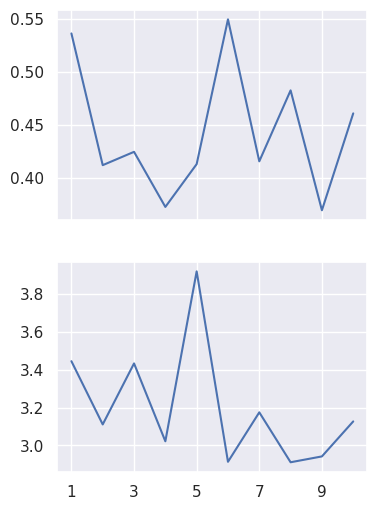

In [35]:
# Plotting the alpha themselves.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='all', figsize=(4, 6))

sns.lineplot(x=np.arange(start=1, stop=len(successful_alphas)+1), y=successful_alphas, ax=ax1)
sns.lineplot(x=np.arange(start=1, stop=len(all_alphas)+1), y=all_alphas, ax=ax2)

ax2.set_xticks(np.arange(start=1, stop=len(successful_alphas)+1, step=2))

## Alternative Scalings

We had assumed the scaling was of the form $1/2^{\alpha n}$, but other scalings like $1/2^{\alpha n^2}$ or $1/2^{\alpha n\log n}$ may be more appropriate. Here we try out the alternatives and see if we like the fit.

According to the abstract of [this paper](https://arxiv.org/pdf/1607.04789.pdf), the best time complexity (as of 2016) is $2^{0.377d+o(d)}$ in high dimensions $d$. The same paper then claims to reduce this to $2^{0.292d+o(d)}$. This would seem to suggest that the scaling is, in fact, $1/2^{\alpha d}$ after all (since this would give a query complexity of $2^{\alpha d}$), and we equate $n$ and $d$ as per the work of Yan et al. (2022). Although, the relationship between the bit-length and lattice dimension may not be as straightforward as first thought, as Yan et al. (2022) kept pretty quite about fiddling with the size of the factor base. It appears they may have decided to consider the square, which would ultimately give us a scaling more like $1/2^{\alpha n}$, but I'm not super clear on whether that is the case. The least we can do for now is try both scalings.

In [139]:
# Define a few scaling functions, named according to the function over the lattice dimension in the exponential.
def linear(x, alpha):
    return 1 / (2 ** (alpha * x))

def quadratic(x, alpha):
    return 1 / (2 ** (alpha * (x ** 2)))

def logarithmic(x, alpha):
    return 1 / (2 ** (alpha * x * np.log(x)))

In [133]:
# Read in some data (we'll use the pretrained p=9 data, which is the most promising scaling in linear).
pretrain_data_9 = pd.read_csv('./results/quantum-accelerated-cvp/qaoa-based-(p=9)-pretraining-huge.csv').drop(columns=['Unnamed: 0'])

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

# Add 'exact' lattice dimension onto it (so we can differentiate points more easily).
pretrain_data_9['Exact Lattice Dimension'] = [
    compute_lattice_dim(N, l) for N, l in zip(pretrain_data_9['N'], pretrain_data_9['l'])
]

As before, successful (i.e. where the probability to improve on the approximate solution is non-zero) only first.

In [153]:
# Filter for success.
pretrain_successful_9 = pretrain_data_9[pretrain_data_9['P(|v_new - t|^2 < |b_op - t|^2)'] > 0]

# Compute each scaling for successful data.
x_data_successful = pretrain_successful_9['Exact Lattice Dimension']
y_data_successful = pretrain_successful_9['P(|v_new - t|^2 < |b_op - t|^2)']

alpha_successful_linear = curve_fit(linear, x_data_successful, y_data_successful)[0][0]
alpha_successful_quadratic = curve_fit(quadratic, x_data_successful, y_data_successful)[0][0]
alpha_successful_logarithmic = curve_fit(logarithmic, x_data_successful, y_data_successful)[0][0]

# Generate the curves' points.
step_size = .1
xs = np.arange(start=2, stop=19+step_size, step=step_size)
ys_successful_linear = [linear(x, alpha_successful_linear) for x in xs]
ys_successful_quadratic = [quadratic(x, alpha_successful_quadratic) for x in xs]
ys_successful_logarithmic = [logarithmic(x, alpha_successful_logarithmic) for x in xs]

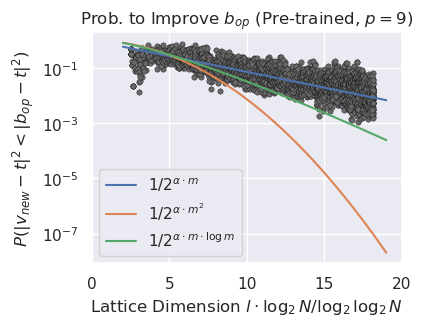

In [160]:
# Plotting those curves over the data.
fig, ax = plt.subplots(figsize=(4, 3))

# The underlying data points.
sns.scatterplot(x='Exact Lattice Dimension', y='P(|v_new - t|^2 < |b_op - t|^2)', data=pretrain_successful_9, color='dimgrey', s=15, edgecolor='k')

# The best-fit curves.
sns.lineplot(x=xs, y=ys_successful_linear, color=sns.color_palette(palette, n_colors=3)[0], label='$1/2^{\\alpha\cdot m}$')
sns.lineplot(x=xs, y=ys_successful_quadratic, color=sns.color_palette(palette, n_colors=3)[1], label='$1/2^{\\alpha\cdot m^2}$')
sns.lineplot(x=xs, y=ys_successful_logarithmic, color=sns.color_palette(palette, n_colors=3)[2], label='$1/2^{\\alpha\cdot m \cdot \log m}$')

ax.set_yscale('log')

ax.set_title('Prob. to Improve $b_{op}$ (Pre-trained, $p=9$)')

ax.set_ylabel('$P(|v_{new} - t|^2 < |b_{op} - t|^2)$')
ax.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')

ax.set_xticks(np.arange(start=0, stop=21, step=5))

plt.savefig('./figures/alternative-scaling-functions-(sampling-improvement).pdf')

Now we'll consider that the approximate solution may already be quite good and so take the probability to sample the best solution, regardless of whether that solution is, in fact, $b_{op}$ itself. Sampling $b_{op}$ and deciding you're satisfied that you have the best solution is a little misguided, especially if you are unaware about the wave function, but studying the probability nevertheless tells us about the number of queries necessary to confidently assure us that we have the best solution, whether that was classically attainable by the approximation or not.

In [159]:
# Compute each scaling.
x_data_best = pretrain_data_9['Exact Lattice Dimension']
y_data_best = pretrain_data_9['P(v_best)']

alpha_best_linear = curve_fit(linear, x_data_best, y_data_best)[0][0]
alpha_best_quadratic = curve_fit(quadratic, x_data_best, y_data_best)[0][0]
alpha_best_logarithmic = curve_fit(logarithmic, x_data_best, y_data_best)[0][0]

# Generate the curves' points.
step_size = .1
xs = np.arange(start=2, stop=19+step_size, step=step_size)
ys_best_linear = [linear(x, alpha_best_linear) for x in xs]
ys_best_quadratic = [quadratic(x, alpha_best_quadratic) for x in xs]
ys_best_logarithmic = [logarithmic(x, alpha_best_logarithmic) for x in xs]

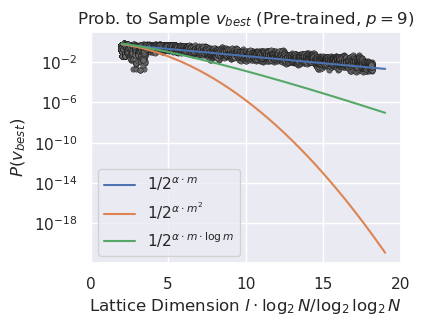

In [174]:
# Plotting those curves over the data.
fig, ax = plt.subplots(figsize=(4, 3))

# The underlying data points.
sns.scatterplot(x='Exact Lattice Dimension', y='P(v_best)', data=pretrain_data_9, color='dimgrey', s=15, edgecolor='k')

# The best-fit curves.
sns.lineplot(x=xs, y=ys_best_linear, color=sns.color_palette(palette, n_colors=3)[0], label='$1/2^{\\alpha\cdot m}$')
sns.lineplot(x=xs, y=ys_best_quadratic, color=sns.color_palette(palette, n_colors=3)[1], label='$1/2^{\\alpha\cdot m^2}$')
sns.lineplot(x=xs, y=ys_best_logarithmic, color=sns.color_palette(palette, n_colors=3)[2], label='$1/2^{\\alpha\cdot m \cdot \log m}$')

ax.set_yscale('log')

ax.set_title('Prob. to Sample $v_{best}$ (Pre-trained, $p=9$)')

ax.set_ylabel('$P(v_{best})$')
ax.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')

ax.set_xticks(np.arange(start=0, stop=21, step=5))

plt.savefig('./figures/alternative-scaling-functions-(sampling-best).pdf')

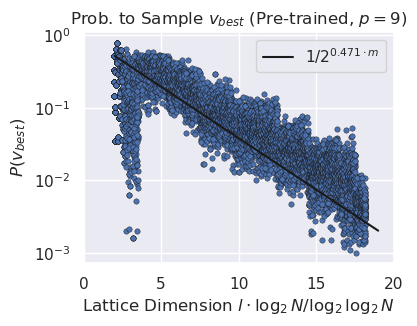

In [181]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.scatterplot(x='Exact Lattice Dimension', y='P(v_best)', data=pretrain_data_9, color=sns.color_palette(palette, n_colors=3)[0], s=15, edgecolor='k')
sns.lineplot(x=xs, y=ys_best_linear, color='k', label='$1/2^{'+str(round(alpha_best_linear, 3))+'\cdot m}$')

ax.set_yscale('log')

ax.set_title('Prob. to Sample $v_{best}$ (Pre-trained, $p=9$)')

ax.set_ylabel('$P(v_{best})$')
ax.set_xlabel('Lattice Dimension $l\cdot\log_2N/\log_2\log_2N$')

ax.set_xticks(np.arange(start=0, stop=21, step=5))

plt.savefig('./figures/prob-to-sample-best-fit-curve.pdf')